In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import arviz as az
import h5py
import pandas as pd
import seaborn as sns
import ringdown as rd
from pyRing import pyRing
from pyRing import likelihood
from pyRing import noise
from tqdm import tqdm

from lal import ComputeDetAMResponseExtraModes, GreenwichMeanSiderealTime, LIGOTimeGPS
from scipy.linalg import inv, toeplitz, cholesky, solve_toeplitz

/work/yifan.wang/virtualenv/ringdown/lib/python3.7/site-packages/pyRing/utils.py:16: UserWarning: surfinBH is not automatically installed due to possible conflicts. If you wish to use its functionalities, it needs to be installed separately.
  warnings.warn("surfinBH is not automatically installed due to possible conflicts. If you wish to use its functionalities, it needs to be installed separately.")


In [2]:
fit = rd.Fit(model='mchi_aligned')

fit.result = az.from_netcdf('/work/yifan.wang/ringdown/GW150914/maxisi-data-release/my_gw150914_fit.nc')

In [3]:
rdoptsnr = fit.compute_posterior_snrs(optimal=True)
rdmfsnr = fit.compute_posterior_snrs(optimal=False)

In [4]:
# stacking the posterior h_det and parameters
hs = fit.result.posterior.h_det.stack(samples=('chain', 'draw'))
A = fit.result.posterior.A.stack(samples=('chain','draw'))
phi = fit.result.posterior.phi.stack(samples=('chain','draw'))
M = fit.result.posterior.M.stack(samples=('chain','draw'))
chi = fit.result.posterior.chi.stack(samples=('chain','draw'))

In [5]:
def read_strain(file, dname):
    with h5py.File(file, 'r') as f:
        t0 = f['meta/GPSstart'][()]
        T = f['meta/Duration'][()]
        h = f['strain/Strain'][:]
    
        dt = T/len(h)
    
        raw_strain = rd.Data(h, index=t0 + dt*np.arange(len(h)), ifo=dname)
        
        return raw_strain

ifos = ['H1', 'L1']
input_path = '/work/yifan.wang/ringdown/GW150914/maxisi-data-release/{i}-{i}1_GWOSC_16KHZ_R1-1126257415-4096.hdf5'
raw_strain = {i: read_strain(input_path.format(i=i[0]), i) for i in ifos}

for s in raw_strain.values():
    fit.add_data(s)
T = 0.2
srate = 2048
fit.set_target(1126259462.4083147, ra=1.95, dec=-1.27, psi=0.82, duration=T)

# condition data
fit.condition_data(ds=int(round(raw_strain[ifos[0]].fsamp/srate)), flow=20,fhigh=1024)
fit.compute_acfs()

# Run Pyring

In [15]:
input_par = {'data-H1': '', 
             'data-L1': '', 
             'data-V1': '', 
             'ignore-data-filename': 0, 
             'download-data': 1, 
             'datalen-download': 4096.0, 
             'gw-data-find': 0, 
             'gw-data-type-H1': '', 
             'gw-data-type-L1': '', 
             'gw-data-type-V1': '', 
             'tag': 'CLN', 
             'channel-H1': 'GWOSC', 
             'channel-L1': 'GWOSC', 
             'channel-V1': 'GWOSC', 
             'config-file': 'config_gw150914_production.ini', 
             'run-type': 'full', 
             'output': 'GW150914_PROD1_Kerr_221_0M', 
             'run-tag': 'PROD1', 
             'screen-output': 0, 
             'pesummary': 1, 
             'trigtime': 1126259462.423, 
             'detectors': ['H1', 'L1'], 
             'ref-det': 'H1', 
             'nonref-det': 'L1',
             'sky-frame': 'equatorial', 
             'acf-H1': '', 
             'acf-L1': '', 
             'acf-V1': '', 
             'psd-H1': '', 
             'psd-L1': '', 
             'psd-V1': '', 
             'signal-chunksize': 4.0, 
             'noise-chunksize': 4.0, 
             'window-onsource': 0, 
             'window': 1, 
             'alpha-window': 0.1, 
             'sampling-rate': 2048, 
             'f-min-bp': 20.0, 
             'f-max-bp': 500.0, 
             'bandpassing': 1, 
             'fft-acf': 1, 
             'acf-simple-norm': 1, 
             'no-lognorm': 0, 
             'truncate': 1, 
             'analysis-duration': 0.2, 
             'analysis-duration-n': int(0.2*2048),
             'zero-noise': 0, 
             'gaussian-noise': '', 
             'gaussian-noise-seed': -1, 
             'gaussian-noise-white-sigma': 1e-21, 
             'chisquare-computation': 0, 
             'non-stationarity-check': 0, 
             'onsource-ACF': 0, 
             'noise-averaging-method': 'mean', 
             'Dirac-comb': 0, 
             'Zeroing-data': 0, 
             'maxent-psd': '', 
             'PSD-investigation': 0, 
             'injection-parameters': None, 
             'injection-approximant': '', 
             'inject-n-ds-modes': {'t': 1}, 
             'inject-area-quantization': 0, 
             'inject-charge': 0, 
             'injection-scaling': 1.0, 
             'injection-T': 64.0, 
             'template': 'Kerr', 
             'single-mode': None, 
             'n-ds-modes': {'t': 1}, 
             'ds-ordering': 'freq', 
             'kerr-modes': [(2, 2, 2, 0), (2, 2, 2, 1)], 
             'reference-amplitude': 1e-21, 
             'spheroidal': 0, 
             'qnm-fit': 1, 
             'coherent-n': 0, 
             'amp-non-prec-sym': 1, 
             'max-Kerr-amp-ratio': 0.0, 
             'TGR-overtones-ordering': 'Unordered', 
             'domega-tgr-modes': None, 
             'dtau-tgr-modes': None, 
             'area-quantization': 0, 
             'tau-AQ': 0, 
             'prior-reweight': 0, 
             'ParSpec': 0, 
             'ParSpec_Dmax_TGR': 2, 
             'ParSpec_Dmax_charge': 0, 
             'EsGB': 0, 
             'charge': 0, 
             'gr-time-prior': 1, 
             'dist-flat-prior': 0, 
             'ds-amp-flat-prior': 0, 
             'mf-time-prior': 67.92493161247017}

In [16]:
test_par = input_par
test_par.update({'f-min-bp':20,
               'f-max-bp':1024})
model = pyRing.KerrModel(modes=input_par['kerr-modes'],**test_par)


Trigtime in H1: 1126259462.423000


Reading data...

Using GWPY to download data.
Fetched 1 URLs from www.gw-openscience.org for [1126257414 .. 1126261510))
Reading data... [Done]

Loaded channel GWOSC starting at 1126257414.0 length 4096.0s.
Bandpassing the raw strain between [20, 1024] Hz.
Downsampling detector data from 16384.0 to 2048 Hz, decimate factor 8
Computing the one-sided PSD with the Welch method and the standard ACF for comparison.
No ACF was passed. Estimating ACF.
Plancherel theorem E(f)/E(t) (expected value: 1) = 1.0658423561471921

Reading data...

Using GWPY to download data.
Fetched 1 URLs from www.gw-openscience.org for [1126257414 .. 1126261510))
Reading data... [Done]

Loaded channel GWOSC starting at 1126257414.0 length 4096.0s.
Bandpassing the raw strain between [20, 1024] Hz.
Downsampling detector data from 16384.0 to 2048 Hz, decimate factor 8
Computing the one-sided PSD with the Welch method and the standard ACF for comparison.
No ACF was passed. Estimating

# Data conditioning wheel

In [17]:
from scipy.signal      import butter, filtfilt, welch, tukey, decimate
from gwpy.timeseries import TimeSeries
import matplotlib.mlab as mlab, sys, warnings
from scipy.interpolate import interp1d
def fetch_data(ifo, tstart, tend, channel=None, path=None, verbose=0, tag=None):

    """
        Fetch data for a particular event

        ifo: IFO name ('H1' etc)
        tstart, tend: start and end time to find
        path: Local path to save file. If file exists it will be read from disk rather than fetched
        channel: Channel to read from frame data. If 'GWOSC' will fetch open data
        verbose: Print some info

        Returns a gwpy.TimeSeries object
    """

    # If file was previously saved, open it.
    if path is not None and os.path.exists(path):
        tseries = TimeSeries.read(path,start=tstart,end=tend)
        if verbose:
            sys.stdout.write('Reading from local file '+path)
        return tseries

    # If not, then see if it is on GWOSC.
    if channel=='GWOSC':
        #When downloading public data, fetch them with the highest possible sampling rate, then pyRing will down-sample internally, if required. This is needed to avoid incompatibilities between GWOSC down-sampling and the pyRing internal one. The actual function used to down-sample is the same, but differences in things like the length of data stretch can affect filtering at the borders and hence the Bayes Factors. 
        tseries = TimeSeries.fetch_open_data(ifo, tstart, tend, sample_rate = 16384, verbose=verbose, cache=True, tag=u"{0}".format(tag))
    else:
        # Read from authenticated data.
        if channel is None:
            raise Exception('Channel not specified when fetching frame data.')
        tseries = TimeSeries.get(channel, tstart, tend, verbose=verbose)
    if path is not None:
        tseries.write(path)

    return tseries

def acf(y, fft=True, simple_norm=False):

    """
        Returns the autocorrelation function: R[i] = sum_n x[n]*x[n+i]
        Returns an array spanned by the index i.
        If `fft`, uses FT method, see section 'Efficient computation' of 
        'https://en.wikipedia.org/wiki/Autocorrelation#cite_note-3
    """

    N = len(y)

    if fft:
        # ACF computation using FFT.
        Y=np.fft.fft(y)
        # We take the real part just to convert the complex output of fft to a real numpy float. The imaginary part if already 0 when coming out of the fft.
        R = np.real(np.fft.ifft(Y*Y.conj()))
        # Divide by an additional factor of 1/N since we are taking two fft and one ifft without unitary normalization, see: https://docs.scipy.org/doc/numpy/reference/routines.fft.html#module-numpy.fft
        acf_normed = R/N
    else:
        # ACF computation without FFT.
        acf_numpy = np.correlate(y, y, mode='full')[N-1:]
        # FIXME: describe the difference between the two normalizations.
        if simple_norm:
            acf_normed = acf_numpy[:N] / N
        else:
            acf_normed = acf_numpy[:N] / (N - np.arange(N))

    return acf_normed

def chunks(times, strain, chunksize, avoid=None, window=False, alpha=0.1):
    """
        Divide the data in chunks. Skip the 0th and the last chunks which have filter ringing from downsampling.
    """
    if avoid is None:
        avoid = times[0]-1e6 # dummy value
    if window:
        win      = tukey(chunksize,alpha=alpha)
    else:
        win      = np.ones(chunksize)
    #The integer division is needed in case the chunk length in seconds is not a sub-multiple of the total strain 
    #length (e.g. after quality veto cuts)
    for j in range(1,len(strain)//chunksize):
        if not times[chunksize*j] < avoid < times[chunksize*(j+1)]:
            yield strain[chunksize*j:chunksize*(j+1)]*win
            
def local_load_data(ifo, **kwargs):

    sys.stdout.write('\nReading data...\n')
    # General parameters that are always needed.
    triggertime       = kwargs['trigtime']
    fft_acf           = kwargs['fft-acf']
    signal_chunk_size = kwargs['signal-chunksize']
    noise_chunk_size  = kwargs['noise-chunksize']
    srate             = kwargs['sampling-rate']
    f_min_bp          = kwargs['f-min-bp']
    f_max_bp          = kwargs['f-max-bp']
    alpha_window      = kwargs['alpha-window']
    signal_seglen     = int(srate*signal_chunk_size)
    noise_seglen      = int(srate*noise_chunk_size)
    psd_window        = tukey(noise_seglen,alpha_window)
    psd_window_norm   = np.sum(psd_window**2)/noise_seglen
    assert not(triggertime is None), "No triggertime given."

    # If no data file was passed either download them or generate them yourself.
    if(kwargs['download-data'] == 1):
        T         = float(kwargs['datalen-download'])
        channel   = kwargs['channel-{}'.format(ifo)]
        starttime = int(triggertime)-(T/2.)
        endtime   = int(triggertime)+(T/2.)
        if((kwargs['gw-data-find']==1) and not(kwargs['gw-data-type-{}'.format(ifo)]=='')):
            connection = datafind.GWDataFindHTTPConnection()
            cache      = connection.find_frame_urls(
                ifo[0], kwargs['gw-data-type-{}'.format(ifo)], starttime, endtime, urltype='file')
            tseries    = TimeSeries.read(cache, channel)
        else:
            sys.stdout.write('\nUsing GWPY to download data.\n')
            tag        = kwargs['tag']
            tseries    = fetch_data(ifo, starttime, endtime, channel=channel, path=None, verbose=2, tag=tag)
        rawstrain               = np.array(tseries.data)
        dt                      = tseries.dt.to_value()
        srate_dt                = tseries.sample_rate.to_value()
        sys.stdout.write('\nLoaded channel {} starting at {} length {}s.\n'.format(channel,starttime,T))
    else:
        raise Exception("Either pass a data file, download data or generate data.")

    assert not((noise_chunk_size > T) or (signal_chunk_size > T)), \
    "Noise ({} s) and signal ({} s) seglens must be shorter than data duration ({})".format(
        noise_chunk_size, signal_chunk_size, T)

    if (not(kwargs['data-{0}'.format(ifo)]=='') or (kwargs['download-data'] == 1)):
        # If there are nans, resize the strain to the longest segment which contains no nans.
        no_nans = 0
        while(no_nans == 0):
            if((np.isnan(rawstrain).any())):
                sys.stdout.write('Nans found in the data. Resizing strain.\n')
                new_rawstrain, new_starttime = resize_nan_strain(
                    rawstrain, starttime, triggertime, signal_chunk_size, dt)
                starttime = new_starttime
                rawstrain = new_rawstrain
            else:
                no_nans = 1
        # Recompute the total length after resizing.
        T = len(rawstrain)*dt

    if(kwargs['bandpassing']):
        # Bandpassing section.
        sys.stdout.write('Bandpassing the raw strain between [{}, {}] Hz.\n'.format(f_min_bp, f_max_bp))
        # Create a Butterworth bandpass filter between [f_min, f_max] and apply it with the function filtfilt.
        bb, ab = butter(4, [f_min_bp/(0.5*srate_dt), f_max_bp/(0.5*srate_dt)], btype='band')
        strain = filtfilt(bb, ab, rawstrain)
    else:
        sys.stdout.write('No bandpassing applied.\n')
        strain = rawstrain
    # Check that the sample rate from the data is the same passed in the configuration file. 
    # In case they are different, either downsample or throw an error.
    if (srate > srate_dt):
        raise ValueError("You requested a sample rate higher than the data sampling.")
    elif (srate < srate_dt):
        sys.stdout.write('Downsampling detector data from {} to {} Hz, decimate factor {}\n'.format(
            srate_dt, srate, int(srate_dt/srate)))
        strain = decimate(strain, int(srate_dt/srate), zero_phase=True)
        dt     = 1./srate
    else:
        pass

    # Compute the index of the trigtime 
    # (estimate of the coalescence time of a signal or the time at which the injection should be placed).
    index_trigtime = int((triggertime-starttime)*srate)

    # Find the on-source chunk, centred on triggertime.
    mask = np.ones(len(strain), dtype=bool)
    if not((signal_seglen%2)==0):
        on_source_strain = strain[index_trigtime-signal_seglen//2:index_trigtime+signal_seglen//2+1]
        mask[range(index_trigtime-signal_seglen//2,index_trigtime+signal_seglen//2+1,1)] = False
    else:
        on_source_strain = strain[index_trigtime-signal_seglen//2:index_trigtime+signal_seglen//2]
        mask[range(index_trigtime-signal_seglen//2,index_trigtime+signal_seglen//2,1)]   = False

    #Excise the on-source chunk to avoid including the signal in the PSD computation.
    psd_strain = tuple((strain)[mask])

    # While it is true that no FFT is applied to the on-source chunk, the ACF is computed on a windowed chunk, \
    #thus to make a consistent likelihood computation, also the onsource chunk must be windowed when no truncation 
    #is applied.
    if (kwargs['window-onsource'] and kwargs['window']):
        if(kwargs['truncate']):
            warnings.warn("The on-source chunk should not be windowed when truncating data.")
        else:
            assert (signal_seglen==noise_seglen), \
            "If a window is applied, the length of the signal chunk and of the noise chunk must be the same, \
            otherwise with the same Tukey alpha-parameter PSD will be underestimated. Either choose different \
            alphas or equal lengths."
        on_source_window = tukey(signal_seglen, alpha=alpha_window)
        on_source_strain = on_source_strain*on_source_window

    times = np.linspace(starttime, starttime+T-dt, len(strain))


    if not(kwargs['signal-chunksize']==kwargs['noise-chunksize']):
        warnings.warn("A different chunksize between signal and noise implies an incorrect normalization \
        of the autocorrelation function. This configuration should not be used for production runs.")
    
    # We are done with the strain.
    del rawstrain, strain

    return on_source_strain

def pyring_time(model):
    waveform_time_array = {}
    dt = {}
    t_start = 0
    for det in ['H1','L1']:
        dt[det]   = model.time_delay['H1_'+det]
        time_array_raw = model.detectors[det].time - (model.tevent+dt[det])
        waveform_time_array[det] = time_array_raw[time_array_raw >= t_start][:model.duration_n] 
    return waveform_time_array,dt

# Read in the data through PyRing data conditioning

In [18]:
pr_data  = {}
for d in model.detectors.keys():
    pr_data[d] = local_load_data(d,**test_par)


Reading data...

Using GWPY to download data.
Fetched 1 URLs from www.gw-openscience.org for [1126257414 .. 1126261510))
Reading data... [Done]

Loaded channel GWOSC starting at 1126257414.0 length 4096.0s.
Bandpassing the raw strain between [20, 1024] Hz.
Downsampling detector data from 16384.0 to 2048 Hz, decimate factor 8

Reading data...

Using GWPY to download data.
Fetched 1 URLs from www.gw-openscience.org for [1126257414 .. 1126261510))
Reading data... [Done]

Loaded channel GWOSC starting at 1126257414.0 length 4096.0s.
Bandpassing the raw strain between [20, 1024] Hz.
Downsampling detector data from 16384.0 to 2048 Hz, decimate factor 8


In [1]:
def project(hs,
            hvx,
            hvy,
            hp,
            hc,
            detector,
            ra,
            dec,
            psi,
            tgps):

    #cdef double gmst, fs, fvx, fvy, fp, fc
    gmst   = GreenwichMeanSiderealTime(tgps)
    #The breathing and longitudinal modes act on a L-shaped detector in the same way up to a constant amplitude, 
    # thus we just use one. See Isi-Weinstein, arxiv 1710.03794
    fp, fc, fb, fs, fvx, fvy = ComputeDetAMResponseExtraModes(detector.response, ra, dec, psi, gmst)
    waveform = fs*hs + fvx*hvx + fvy*hvy + fp*hp + fc*hc

    return waveform
def inner_product(C,X):
    return np.dot(X,np.dot(C,X))
def loglikelihood_core(residuals,inverse_covariance,log_normalisation):
    return -0.5*inner_product(inverse_covariance, residuals) + log_normalisation



class pyring_wheel():
    def __init__(self,model,fit=None):
        '''
        A wheel to reproduce the PyRing loglikelihood and SNR computation
        
        Parameter:
        ----------
        model: pyRing.KerrModel
            The KerrModel for pyring
        pyring_par: dict
            waveform parameters
        '''
        self.model = model
        
        self.data = {}
        self.cinv = {}
        self.acf = {}
        self.acf_from_psd = {}
        self.cinv_acf_from_psd = {}
        self.cinv_acf_from_ringdown = {}
        self.L = {}
        self.white_d = {}
        
        self.have_run_model = 0
        
        #To activate model.time_delay we need to run loglikelihood first
        pyring_par = {'Mf': 72.84400244,
                     'af': 0.72848178,
                     'A2220': 5.595449455544791,
                     'A2221': 6.457081321435618,
                     'phi2220': -0.9737754582321143,
                     'phi2221': 1.652119726595113}
        _ = model.log_likelihood(pyring_par)
        waveform_model = model.get_waveform(pyring_par)
        t_start = model.fixed_params['t']
        duration_n = model.duration_n
    
        for d in model.detectors.keys():
            dt   = model.time_delay['{0}_'.format(self.model.ref_det)+d]
            tref = LIGOTimeGPS(t_start+dt+self.model.tevent)
            # crop data
            time_array_raw = self.model.detectors[d].time - (self.model.tevent+dt)
            time_array     = time_array_raw[time_array_raw >= t_start][:duration_n]
            self.data[d]   = self.model.detectors[d].time_series[time_array_raw >= t_start][:duration_n]
            self.cinv[d] = self.model.detectors[d].inverse_covariance
            # read in the acf
            self.acf[d] = np.loadtxt(
                './GW150914_PROD1_Kerr_221_0M/Noise/ACF_TD_cropped_'+str(d)+'_1126257414_4096_4.0_2048_0.2.txt')
            psd = np.loadtxt(
                './GW150914_PROD1_Kerr_221_0M/Noise/PSD_'+str(d)+'_1126257414_4096_4.0_2048.txt')
            acf_psd = 0.5*np.fft.irfft(psd[:,1]) * self.model.srate
            c = toeplitz(acf_psd[:model.duration_n])
            self.cinv_acf_from_psd[d] = inv(c)
            if fit is not None:
                acf = fit.acfs[d].values[:model.duration_n]
                c = toeplitz(acf_psd[:model.duration_n])
                self.cinv_acf_from_ringdown[d] = inv(c)
            
            
    def get_hstrain(self,pyring_par):
        h = {}
        #To activate model.time_delay we need to run loglikelihood first
        _ = self.model.log_likelihood(pyring_par)
        waveform_model = self.model.get_waveform(pyring_par)
        t_start = self.model.fixed_params['t']
        ra = self.model.fixed_params['ra']
        dec = self.model.fixed_params['dec']
        psi = self.model.fixed_params['psi']
        t_start = self.model.fixed_params['t']
        duration_n = self.model.duration_n
    
        for d in self.model.detectors.keys():
            dt   = self.model.time_delay['{0}_'.format(self.model.ref_det)+d]
            tref = LIGOTimeGPS(t_start+dt+self.model.tevent)
            # crop data
            time_array_raw = self.model.detectors[d].time - (self.model.tevent+dt)
            time_array     = time_array_raw[time_array_raw >= t_start][:duration_n]
            wf_model = waveform_model.waveform(time_array)
            hs, hvx, hvy, hp, hc = wf_model[0], wf_model[1], wf_model[2], wf_model[3], wf_model[4]
            h[d]  = project(hs, hvx, hvy, hp, hc, self.model.detectors[d].lal_detector, ra, dec, psi, tref)
        return h
    
    def logL(self):
        loglikelihood = 0
        for d in model.detectors.keys():
            residuals = self.data[d] - self.hstrain[d]
            loglikelihood += loglikelihood_core(residuals, self.cinv[d],self.model.detectors[d].log_normalisation)
        return loglikelihood
    
    def optsnr(self,pyring_par,network=True,acf_from_psd=False,acf_from_ringdown=False):
        '''
        Optimal SNR
        
        Parameters:
        network: bool
            If true, return network SNR
        use_rd_l: bool
            If true, use the L from Ringdown, where C=LL^T (cholesky decomposition)
        -----------
        '''    
        h = self.get_hstrain(pyring_par)
        snr = {}
        
        for d in model.detectors.keys():
            if acf_from_psd == True:
                cinv = self.cinv_acf_from_psd[d]
            elif acf_from_ringdown:
                cinv = self.cinv_acf_from_ringdown[d]
            else:
                cinv = self.cinv[d]
            snr[d] = np.dot(h[d],np.dot(cinv,h[d]))
            
        if network:
            result = 0
            for d in model.detectors.keys():
                result += snr[d]
            return np.sqrt(result)
        else:
            for d in model.detectors.keys():
                snr[d] = np.sqrt(snr[d]) 
            return snr
    
    def mfsnr(self,pyring_par,network=True,acf_from_psd=False,acf_from_ringdown=False):
        '''
        Matched-filter SNR
        
        Parameters:
        -----------
        '''    
        h = self.get_hstrain(pyring_par)
        
        snr = {}
        for d in model.detectors.keys():
            if acf_from_psd == True:
                cinv = self.cinv_acf_from_psd[d]
            elif acf_from_ringdown:
                cinv = self.cinv_acf_from_ringdown[d]
            else:
                cinv = self.cinv[d]
            snr[d] = np.dot(self.data[d],np.dot(cinv,h[d]))**2 \
                        /np.dot(h[d],np.dot(cinv,h[d]))

        if network:
            result = 0
            for d in model.detectors.keys():
                result += snr[d]
            return np.sqrt(result)
        else:
            for d in model.detectors.keys():
                snr[d] = np.sqrt(snr[d]) 
            return snr
    
    def optsnr_cholesky(self):
        '''
        Compute the optimal SNR with Cholesky decomposition
        
        Parameters:
        -----------
        '''
        snr = 0 
        for d in model.detectors.keys():
            self.L[d] = np.linalg.cholesky(self.c[d])
            self.white_d[d] = np.linalg.solve(self.L[d], self.data[d])
            white_h = np.linalg.solve(self.L[d], self.hstrain[d])
            snr += np.sum(white_h**2)
        return np.sqrt(snr)

    def mfsnr_cholesky(self):
        '''
        Compute the matched-filter SNR with Cholesky decomposition
        
        Parameters:
        -----------
        '''
        snr = 0 
        for d in model.detectors.keys():
            self.L[d] = np.linalg.cholesky(self.c[d])
            self.white_d[d] = np.linalg.solve(self.L[d], self.data[d])
            white_h = np.linalg.solve(self.L[d], self.hstrain[d])
            snr += np.sum(self.white_d[d]*white_h)**2  / np.sum(white_h*white_h)
        return np.sqrt(snr)
    
    def optsnr_solvetoe(self):
        '''
        Compute the optimal SNR with Solve Toeplitz Method
        
        Parameters:
        -----------
        '''
        snr = 0 
        for d in model.detectors.keys():
            snr += np.dot(self.hstrain[d],solve_toeplitz(self.acf[d],self.hstrain[d]))
        return np.sqrt(snr)
    
    def mfsnr_solvetoe(self):
        '''
        Compute the optimal SNR with Solve Toeplitz Method
        
        Parameters:
        -----------
        '''
        snr = 0 
        for d in model.detectors.keys():
            snr += np.dot(self.data[d],solve_toeplitz(self.acf[d],self.hstrain[d]))**2 \
                        /np.dot(self.hstrain[d],solve_toeplitz(self.acf[d],self.hstrain[d]))
        return np.sqrt(snr)

def compute_pyring_snr(model,fit=None,network=True,acf_from_psd=False,acf_from_ringdown=False):
    '''
    Loop compute the optimal SNR and matched-filter SNR given a PyRing Model
    and parameters from Ringdown
    
    Output:
    -------
    Optimal SNR, Matched-Filtering SNR: np.array()
    '''
    
    #Initialization
    if network:
        optsnr = []
        mfsnr = [] 
    else:
        optsnr = {}
        mfsnr = {}
        for d in model.detectors.keys():
            optsnr[d] = []
            mfsnr[d] = []
    result = pyring_wheel(model,fit)        
    for i in tqdm(range(4000)):
        prefactor = np.sqrt(16*np.pi/5)
        pyring_par = {'Mf': M[i].values,
                  'af': chi[i].values,
                  'A2220': A[0][i].values/1e-21*prefactor,
                  'A2221': A[1][i].values/1e-21*prefactor,
                  'phi2220': -phi[0][i].values,
                  'phi2221': -phi[1][i].values}

        if network:
            optsnr.append(result.optsnr(pyring_par,network,acf_from_psd,acf_from_ringdown))
            mfsnr.append(result.mfsnr(pyring_par,network,acf_from_psd,acf_from_ringdown))
        else:
            for d in model.detectors.keys():
                optsnr[d].append(result.optsnr(pyring_par,network,acf_from_psd,acf_from_ringdown)[d])
                mfsnr[d].append(result.mfsnr(pyring_par,network,acf_from_psd,acf_from_ringdown)[d])

    return optsnr,mfsnr

def plotsnr(rdsnr,prsnr,snr='Optimal SNR'):
    %matplotlib inline
    fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
    inches_per_pt = 1.0/72.27               # Convert pt to inch
    golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*golden_mean      # height in inches
    fig_size =  [fig_width,fig_height]
    params = { 'axes.labelsize': 24,
              'font.family': 'serif',
              'font.serif': 'Computer Modern Raman',
              'font.size': 24,
              'legend.fontsize': 20,
              'xtick.labelsize': 24,
              'ytick.labelsize': 24,
              'axes.grid' : True,
              'text.usetex': True,
              'savefig.dpi' : 100,
              'legend.frameon': True,
              'legend.loc': 'best',
              'lines.markersize' : 14,
              'figure.figsize': fig_size}
    mpl.rcParams.update(params)

    plt.figure(figsize=[16,10])
    plt.subplot(211)
    plt.plot(rdsnr,label='Ringdown '+snr)
    plt.plot(prsnr,alpha=0.5,label='PyRing '+snr)
    plt.title(snr,fontsize=20)
    plt.legend(loc='best',ncol=2)
    plt.subplot(212)
    plt.plot(rdsnr - prsnr,color='grey')
    plt.ylabel('Ringdown SNR - PyRing SNR')
    plt.xlabel('Number of samples')

# Plot data and waveform template in the same figure

In [2]:
rd_data = {}
for d in ['H1','L1']:
    rd_data[d] = fit.data[d]
    rd_data[d] = rd_data[d][(rd_data[d].index >= model.detectors['H1'].time[0]) \
                            & (rd_data[d].index <= model.detectors['H1'].time[-1])]

NameError: name 'fit' is not defined

In [22]:
i = np.argmax(rdmfsnr)
prefactor = np.sqrt(16*np.pi/5)
pyring_par = {'Mf': M[i].values,
                  'af': chi[i].values,
                  'A2220': A[0][i].values/1e-21*prefactor,
                  'A2221': A[1][i].values/1e-21*prefactor,
                  'phi2220': -phi[0][i].values,
                  'phi2221': -phi[1][i].values}
    
result = pyring_wheel(model)

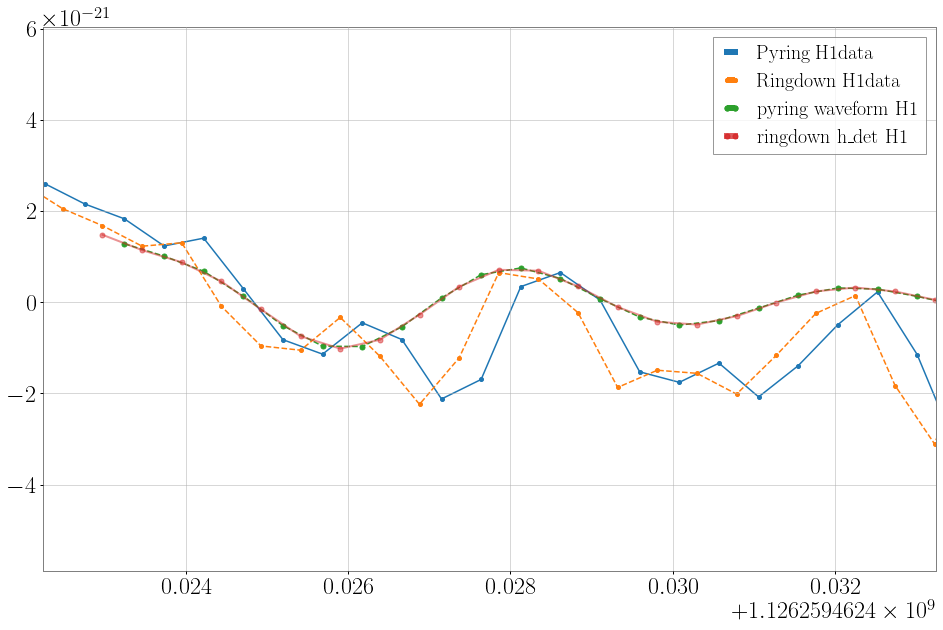

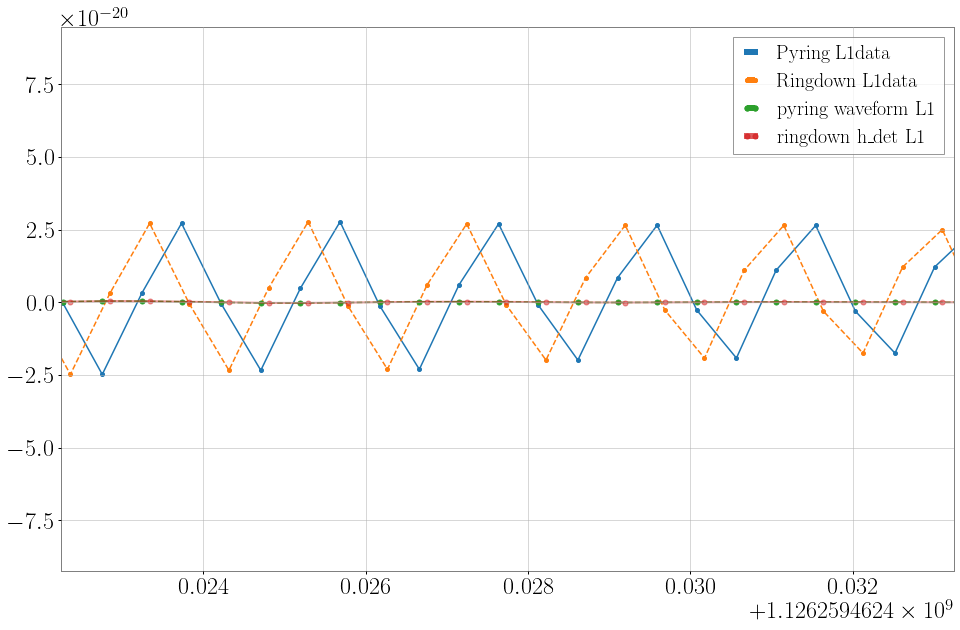

In [23]:
wf_time_array,dt = pyring_time(model)
for d in model.detectors.keys():
    plt.figure(figsize=[16,10])
    plt.plot(model.detectors[d].time,pr_data[d],marker='o',ms=4,label='Pyring '+str(d)+'data')
    plt.plot(rd_data[d].index,rd_data[d],ls='--',marker='o',ms=4,label='Ringdown '+str(d)+'data')

    #plot waveform
    time_array,dt = pyring_time(model)    
    plt.plot(model.tevent+wf_time_array[d]+dt[d],result.get_hstrain(pyring_par)[d],
             ls='--',marker='o',ms=5,label='pyring waveform '+str(d))
    if d == 'H1':
        hsi=0
    else:
        hsi=1
    plt.plot(fit.analysis_data[d].index,hs[hsi,:,i],alpha=0.5,lw=2,marker='o',ms=5,label='ringdown h_det '+str(d))
    
    middle = model.detectors[d].time[len(model.detectors[d].time)//2]
    plt.xlim(middle-0.001,middle+0.01)
    plt.legend()
    plt.savefig('/work/yifan.wang/public_html/GWevents/figure/'+str(d)+'.png',bbox_inches='tight')